# Perform EDA on data captured in DB

In [1]:
import pandas as pd

In [2]:
comments_df = pd.read_csv("data/comments.csv", index_col = 0, encoding = "utf_8")

In [3]:
comments_df.shape

(3507, 9)

In [4]:
comments_df.describe(include = "all")

,insert_update_ts,id,link_id,subreddit_name,author,body,score,permalink,retrieved
count,3507,3507,3507,3507,3507,3507,3507.000000,3507,3507
unique,3051,3507,232,3,3072,3478,NaN,3507,3047
top,2020-05-21 16:57:21,frcnfm2,t3_gnuj72,t5_2qh3l,autotldr,b'[deleted]',NaN,/r/news/comments/gnq41k/michael_cohen_to_be_re...,2020-05-21 20:57:21
freq,4,1,574,2530,46,23,NaN,1,4
mean,NaN,NaN,NaN,NaN,NaN,NaN,36.305104,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,355.748017,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,-244.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN


## NaN or NULL values are indicated with body = "b'[deleted]'"

In [5]:
comments_df.isna().sum()

insert_update_ts    0
id                  0
link_id             0
subreddit_name      0
author              0
body                0
score               0
permalink           0
retrieved           0
dtype: int64

In [6]:
deleted_body_index = comments_df[comments_df["body"]== "b'[deleted]'"].index

In [7]:
no_author_index = comments_df[comments_df["author"]== "None"].index

> ### Also, accounts that have been deleted or (possibly) suspended in some way show up with "author" set to "None"

In [8]:
deleted_body_index.isin(no_author_index).sum()

23

> ### In fact, all of the current records with deleted body content are a subset of the records with no author. In order to cover both possible scenarios we'll filter out records where the body content has been deleted and where the author has been set to "None".

In [9]:
comments_df = comments_df[(comments_df["author"] != "None")&(comments_df["body"] != "b'[deleted]'")]

In [10]:
comments_df.shape

(3480, 9)

### Most common authors

In [11]:
round(comments_df["author"].value_counts(normalize = True),4)[:10] # the authors autotldr & AutoModerator are bots :)

autotldr            0.0132
EdDelahanty         0.0029
Upper_Designer      0.0020
Speedster4206       0.0017
AutoModerator       0.0017
honklersheros       0.0014
thought_first       0.0014
Mountains_beyond    0.0014
BeeAce              0.0014
polipuncher         0.0011
Name: author, dtype: float64

In [12]:
comments_df = comments_df[(comments_df["author"] != "autotldr")&(comments_df["author"] != "AutoModerator")]

In [13]:
comments_df.shape

(3428, 9)

## Add linguistic features

In [14]:
import textstat

In [15]:
comments_df["body_len"] = comments_df.apply(lambda x: len(x["body"]), axis = 1)

In [16]:
comments_df["sent_count"] = comments_df.apply(lambda x: textstat.sentence_count(x["body"]), axis = 1)
comments_df["flesch_read"] = comments_df.apply(lambda x: textstat.flesch_reading_ease(x["body"]), axis = 1)
comments_df["difficult_words"] = comments_df.apply(lambda x: textstat.difficult_words(x["body"]), axis = 1)
comments_df["read_index"] = comments_df.apply(lambda x: textstat.automated_readability_index(x["body"]), axis = 1)
comments_df["syllable_count"] = comments_df.apply(lambda x: textstat.syllable_count(x["body"]), axis = 1)
comments_df["text_standard"] = comments_df.apply(lambda x: textstat.text_standard(x["body"], float_output = True), axis=1)

In [17]:
comments_df.sample(3)

,insert_update_ts,id,link_id,subreddit_name,author,body,score,permalink,retrieved,body_len,sent_count,flesch_read,difficult_words,read_index,syllable_count,text_standard
945,2020-05-21 16:29:03,frb2q2s,t3_gnnjwr,t5_2qh11,enjaegreg,b'Guy is living in 3020',24,/r/offbeat/comments/gnnjwr/restaurant_owner_ma...,2020-05-21 20:29:03,24,1,100.24,0,-0.2,6,0.0
2540,2020-05-21 16:52:50,frcz1lj,t3_gnvud3,t5_2qh3l,poopnada,b'this isnt all that abnormal for corpus christi',-1,/r/news/comments/gnvud3/active_shooter_situati...,2020-05-21 20:52:50,49,1,71.82,3,7.3,12,10.0
2769,2020-05-21 17:04:11,frd6t5c,t3_go0j26,t5_2qh13,FeelingPsychology,b'Can America please buy Trudeau?',-10,/r/worldnews/comments/go0j26/china_doesnt_seem...,2020-05-21 21:04:11,34,1,83.32,0,9.3,7,3.0


In [18]:
comments_df.groupby("subreddit_name").mean()

,score,body_len,sent_count,flesch_read,difficult_words,read_index,syllable_count,text_standard
subreddit_name,,,,,,,,
t5_2qh11,18.169451,107.465394,1.379475,65.974558,2.914081,14.918138,24.673031,6.517900
t5_2qh13,11.488889,171.935354,1.612121,63.689374,5.187879,13.669495,40.793939,8.393939
t5_2qh3l,45.172633,172.387430,1.731504,68.836619,4.688146,12.150438,40.564041,8.116945


In [64]:
comments_df.describe()

,score,body_len,sent_count,flesch_read,difficult_words,read_index,syllable_count,text_standard
count,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000
mean,37.008168,164.386814,1.671237,67.743536,4.543466,12.708081,38.654901,7.961494
std,359.767749,218.657661,1.355907,45.674779,6.843503,17.393757,52.627587,6.567841
min,-244.000000,6.000000,1.000000,-809.390000,0.000000,-9.200000,1.000000,-2.000000
25%,1.000000,55.000000,1.000000,56.930000,1.000000,5.975000,12.000000,4.000000
50%,2.000000,100.000000,1.000000,73.610000,3.000000,9.300000,23.000000,7.000000
75%,5.000000,188.250000,2.000000,88.377500,5.000000,14.425000,45.000000,10.000000
max,9969.000000,5509.000000,19.000000,121.220000,191.000000,374.700000,1333.000000,119.000000


### Distributions for score & body_len

In [20]:
import matplotlib.pyplot as plt

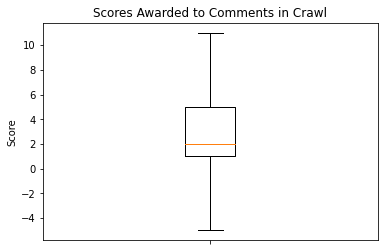

In [21]:
plt.boxplot(x = comments_df["score"], showfliers = False);
plt.tick_params(labelbottom = False)
plt.ylabel("Score");
plt.title(label = "Scores Awarded to Comments in Crawl");

In [76]:
# np.mean(comments_df["score"]), np.median(comments_df["score"]), np.min(comments_df["score"]), np.max(comments_df["score"]), np.max(comments_df["score"])-np.min(comments_df["score"])

In [74]:
# q75, q25 = np.percentile(comments_df["score"], [75 ,25])
# q75 - q25

> ### Comments have a mean score of 37 and a range of 10,213 (from -244 to 9969). However, what we see in the boxplot above may give a better sense of the location of the score data. We can see the median is 2 and the IQR is 4 (75th percentile = 5, 25th percentile = 1).

In [22]:
import numpy as np

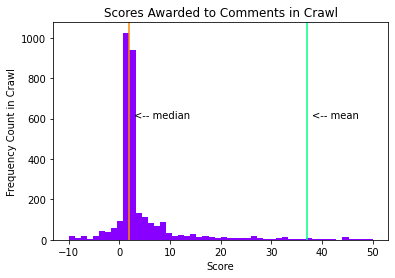

In [23]:
plt.hist(x = comments_df["score"], bins = 50, range = (-10, 50), color = "#8800ff");
plt.xlabel("Score")
plt.ylabel("Frequency Count in Crawl")
plt.axvline(x = np.mean(comments_df["score"]), color = "#00ff88")
plt.axvline(x = np.median(comments_df["score"]), color = "#ff8800") # orange is median
plt.title(label = "Scores Awarded to Comments in Crawl");
plt.annotate(s = "<-- mean", xy = (np.mean(comments_df["score"])+1,600));
plt.annotate(s = "<-- median", xy = (np.median(comments_df["score"])+1,600));

> ### The scores awarded to the comments in the crawl are right-skewed with a median value of 2.0 and a mean value of 37. The maximum score in the crawl was 9969.

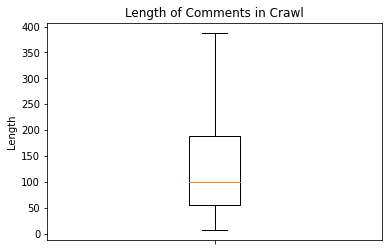

In [44]:
plt.boxplot(x = comments_df["body_len"], showfliers = False);
plt.tick_params(labelbottom = False)
plt.ylabel("Length");
plt.title(label = "Length of Comments in Crawl");

In [78]:
# np.mean(comments_df["body_len"]), np.median(comments_df["body_len"]), np.min(comments_df["body_len"]), np.max(comments_df["body_len"]), np.max(comments_df["body_len"])-np.min(comments_df["body_len"])

In [71]:
# q75, q25 = np.percentile(comments_df["body_len"], [75 ,25])
# q75 - q25

> ### Length of comments have a mean of 164 and a range of 5503 (6 to 5509). Similar to above, the boxplot may give a better sense of the location of the length of the comment data. The median is 100 and the IQR is ~133 (75th percentile = 188, 25th percentile = 55).

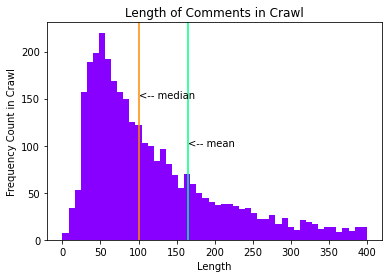

In [53]:
plt.hist(x = comments_df["body_len"], bins = 50, range = (0, 400), color = "#8800ff");
plt.xlabel("Length")
plt.ylabel("Frequency Count in Crawl")
plt.axvline(x = np.mean(comments_df["body_len"]), color = "#00ff88")
plt.axvline(x = np.median(comments_df["body_len"]), color = "#ff8800") # orange is median
plt.title(label = "Length of Comments in Crawl");
plt.annotate(s = "<-- mean", xy = (np.mean(comments_df["body_len"])+1,100));
plt.annotate(s = "<-- median", xy = (np.median(comments_df["body_len"])+1,150));

### Ngram analysis

In [24]:
from nltk import ngrams

comments_df["body_1gram"] = comments_df.apply(lambda x: [i for i in ngrams(x["body"].lower().split(),1)], axis = 1)
comments_df["body_2gram"] = comments_df.apply(lambda x: [i for i in ngrams(x["body"].lower().split(),2)], axis = 1)
comments_df["body_3gram"] = comments_df.apply(lambda x: [i for i in ngrams(x["body"].lower().split(),3)], axis = 1)

In [25]:
import collections

In [26]:
counter_1gram = collections.Counter()
for i in comments_df["body_1gram"]:
    counter_1gram.update(i)
    
for i in counter_1gram.most_common(10):
    print(i,"\n")

(('the',), 3693) 

(('to',), 2619) 

(('a',), 2302) 

(('and',), 1934) 

(('of',), 1605) 

(('in',), 1354) 

(('is',), 1289) 

(('that',), 1098) 

(('for',), 860) 

(('this',), 858) 



In [27]:
counter_2gram = collections.Counter()
for i in comments_df["body_2gram"]:
    counter_2gram.update(i)

for i in counter_2gram.most_common(10):
    print(i,"\n")

(('in', 'the'), 315) 

(('of', 'the'), 281) 

(('to', 'be'), 201) 

(('to', 'the'), 146) 

(('is', 'a'), 136) 

(('on', 'the'), 135) 

(('for', 'the'), 126) 

(('going', 'to'), 121) 

(('this', 'is'), 119) 

(('in', 'a'), 109) 



In [28]:
counter_3gram = collections.Counter()
for i in comments_df["body_3gram"]:
    counter_3gram.update(i)
    
for i in counter_3gram.most_common(10):
    print(i,"\n")

(('is', 'going', 'to'), 30) 

(('to', 'wear', 'a'), 29) 

(('a', 'lot', 'of'), 28) 

(('in', 'a', 'free'), 26) 

(('wear', 'a', 'mask'), 25) 

(('needs', 'to', 'be'), 25) 

(('going', 'to', 'be'), 24) 

(('up', 'in', 'a'), 21) 

(('the', 'middle', 'of'), 21) 

(('people', 'in', 'their'), 20) 



### Cleaning text for refined ngram analysis

In [29]:
from nltk.corpus import stopwords

In [30]:
punct = [":","'",".",",","!","?",")","(","''","&","*","^","$","#","@","~","`","+","/","|","-","--"]
nums = ["1","2","3","4","5","6","7","8","9","0"]

In [31]:
import re

In [32]:
# Remove single characters

replace_chars = []
for i in comments_df["body"]:
    these_chars = ""
    temp_text = i.lower().replace("b'","").replace('b"',"")
    for i in temp_text:
        if i in punct:
            these_chars += ""
        elif i in nums:
            these_chars += ""
        else:
            these_chars += i
    replace_chars.append(these_chars)

In [33]:
stopWords = set(stopwords.words('english'))

# Addl words to potentially add to stopWords
# tho, altho, eventho

In [34]:
# Remove whole tokens

replace_tokens = []
for i in replace_chars:
    temp = []
    for j in i.split():
        if j in stopWords:
            pass
        else:
            temp.append(j)
    replace_tokens.append(temp)

In [35]:
### Replace tokens with lemmas
# May be more general & interesting than actual tokens

In [36]:
### Find & remove hyperlinks (?)
# They take the form of [text to show](url for link). For instance,"There was [a similar scene where a flat earther refused to wear a mask](https://www.youtube.com/watch?v=avQe1ZWKoac)."

### Ngrams without punctuation, numbers, or stopwords

In [37]:
replace_1gram = []
for i in replace_tokens:
    temp = []
    for j in ngrams(i,1):
        temp.append(j)
    replace_1gram.append(temp)
    
counter_1gram = collections.Counter()
for i in replace_1gram:
    counter_1gram.update(i)

for i in counter_1gram.most_common(10):
    print(i,"\n")

(('people',), 492) 

(('like',), 405) 

(('get',), 300) 

(('would',), 259) 

(('one',), 233) 

(('time',), 190) 

(('police',), 190) 

(('going',), 164) 

(('know',), 159) 

(('go',), 156) 



In [38]:
replace_2gram = []
for i in replace_tokens:
    temp = []
    for j in ngrams(i,2):
        temp.append(j)
    replace_2gram.append(temp)

counter_2gram = collections.Counter()
for i in replace_2gram:
    counter_2gram.update(i)

for i in counter_2gram.most_common(10):
    print(i,"\n")

(('wear', 'mask'), 46) 

(('every', 'year'), 39) 

(('wearing', 'mask'), 33) 

(('free', 'country'), 33) 

(('sounds', 'like'), 27) 

(('million', '\\n\\\\'), 26) 

(('new', 'policy'), 24) 

(('years', 'ago'), 20) 

(('looks', 'like'), 19) 

(('make', 'sure'), 19) 



In [41]:
replace_3gram = []
for i in replace_tokens:
    temp = []
    for j in ngrams(i,3):
        temp.append(j)
    replace_3gram.append(temp)

counter_3gram = collections.Counter()
for i in replace_3gram:
    counter_3gram.update(i)

for i in counter_3gram.most_common(10):
    print(i,"\n")

(('reeeeee', 'reeee', 'reeee'), 18) 

(('reeee', 'reeee', 'ree'), 18) 

(('reeee', 'ree', '\\nreeeeeeeeee'), 17) 

(('ree', '\\nreeeeeeeeee', 'reeeeee'), 17) 

(('\\nreeeeeeeeee', 'reeeeee', 'reeee'), 17) 

(('na', 'na', 'na'), 13) 

(('woke', 'free', 'country'), 8) 

(('hand', 'said', 'officers'), 6) 

(('said', 'officers', 'knocked'), 6) 

(('officers', 'knocked', 'door'), 6) 

